In [1]:
#.Packages
import os.path as path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fathon
from fathon import fathonUtils as fu
plt.style.use(['science','notebook'])

In [2]:
#.Data reading
url_darwin = 'https://crudata.uea.ac.uk/cru/data/soi/soi_dar.dat'
url_tahiti = 'https://crudata.uea.ac.uk/cru/data/soi/soi_tah.dat'
url_soi = 'https://crudata.uea.ac.uk/cru/data/soi/soi_3dp.dat'
urls = [url_darwin, url_tahiti, url_soi]

p_darwin = './data/soi_dar.dat'
p_tahiti = './data/soi_tah.dat'
p_soi = './data/soi_3dp.dat'
p_bei = './data/BEI.dat'

paths = [p_darwin, p_tahiti, p_soi, p_bei]
df = []
for i in range(4):
    p = paths[i]
    if path.exists(p):
        df.append(pd.read_table(paths[i], header=None, delim_whitespace=True))
    else:
        f.append(pd.read_table(urls[i], header=None, delim_whitespace=True))
        print("None")
darwin = df[0]
tahiti = df[1]
soi = df[2]
bei = df[3]

In [3]:
#.Data tidying

#.Rename columns
darwin.rename(columns={0: 'Year'},inplace=True)
tahiti.rename(columns={0: 'Year'},inplace=True)
soi.rename(columns={0: 'Year', 13:'Annual'},inplace=True)
bei.rename(columns={0: 'Year'},inplace=True)

#.Write nan values
darwin[darwin==-990]=np.nan
tahiti[tahiti==-990]=np.nan
soi[soi==99.990]=np.nan
soi[soi==-99.990]=np.nan
bei.rename(columns={0: 'Year'},inplace=True)

#.Pivot data
darwin = darwin.reset_index()
da=pd.melt(darwin, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12],var_name='Month',value_name='Pressure')

tahiti = tahiti.reset_index()
ta=pd.melt(tahiti, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12],var_name='Month',value_name='Pressure')

soi = soi.reset_index()
so=pd.melt(soi, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12,'Annual'],var_name='Month',value_name='Pressure')

bei = bei.reset_index()
be=pd.melt(bei, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12],var_name='Month',value_name='Pressure')

#.Drop nan values
so.dropna()
ta.dropna()
da.dropna()
be.dropna()

#Join all data
historical = da.merge(ta, how='inner', on=['Year','Month'])  #Add tahiti to darwin measurements
historical = historical.merge(so, how='inner', on=['Year','Month'])  #Add SOI index
historical = historical.rename(columns={'Pressure_x':'Darwin','Pressure_y':'Tahiti','Pressure':'SOI'}) 
#.Divide by 10 some measurements
historical['Darwin'] = historical['Darwin'] / 10
historical['Tahiti'] = historical['Tahiti'] / 10
historical.dropna()
historical.sort_values(by=['Year','Month'],inplace=True)
#.Dataframe with dates (without days)
dates = pd.to_datetime(historical['Month'].astype(str)+'/'+historical['Year'].astype(str)).dt.date.apply(lambda x: x.strftime('%Y-%m'))
darwin = historical['Darwin']
tahity = historical['Tahiti']
soi = historical['SOI']
year = historical['Year']
bei = be['Pressure']
year_2 = be['Year']

## MFDCCA analysis

In [4]:
a = fu.toAggregated(darwin)
b = fu.toAggregated(tahity)
c = fu.toAggregated(soi)

### Darwin vs Tahity

In [27]:
pymfdcca = fathon.MFDCCA(a, b)
start = 10
#stop = len(a)/4
stop = 400
sStep = 5
winSizes = fu.linRangeByStep(start, stop, step=sStep)
polOrd = 1
revSeg = False
qs = np.arange(-8, 9, 0.5)

n, F = pymfdcca.computeFlucVec(winSizes, qs, revSeg=revSeg, polOrd=polOrd)
list_H, list_H_intercept = pymfdcca.fitFlucVec()

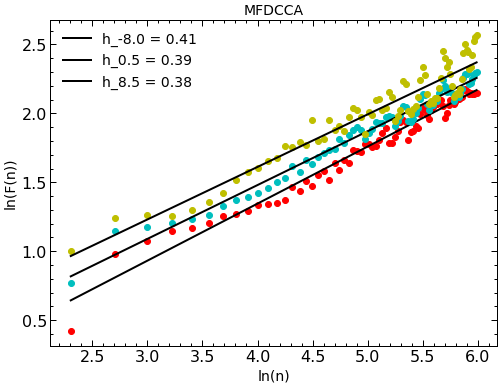

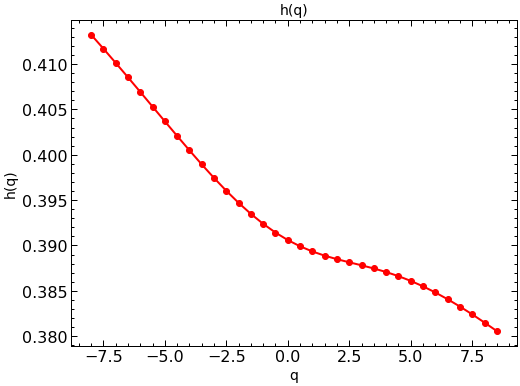

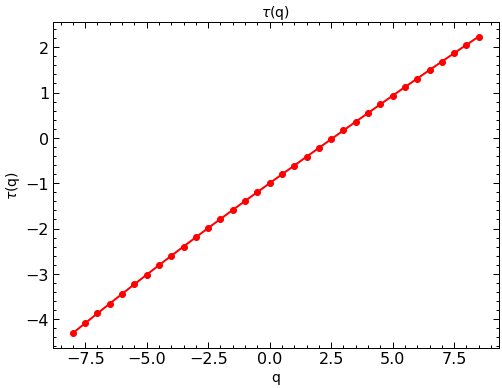

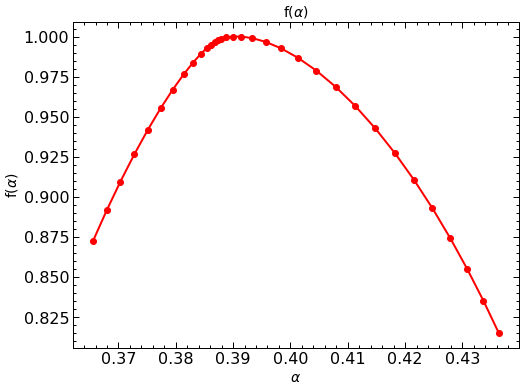

In [28]:
plt.plot(np.log(n), np.log(F[0, :]), 'ro')
plt.plot(np.log(n), list_H_intercept[0]+list_H[0]*np.log(n), 'k-', label='h_{:.1f} = {:.2f}'.format(qs[0], list_H[0]))
half_idx = int(len(qs)/2)
plt.plot(np.log(n), np.log(F[half_idx, :]), 'co')
plt.plot(np.log(n), list_H_intercept[half_idx]+list_H[half_idx]*np.log(n),
         'k-', label='h_{:.1f} = {:.2f}'.format(qs[half_idx], list_H[half_idx]))
plt.plot(np.log(n), np.log(F[-1, :]), 'yo')
plt.plot(np.log(n), list_H_intercept[-1]+list_H[-1]*np.log(n), 'k-',
         label='h_{:.1f} = {:.2f}'.format(qs[-1], list_H[-1]))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('MFDCCA', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.show()

plt.plot(qs, list_H, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('h(q)', fontsize=14)
plt.title('h(q)', fontsize=14)
plt.show()

tau = pymfdcca.computeMassExponents()

plt.plot(qs, tau, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('$\\tau$(q)', fontsize=14)
plt.title('$\\tau$(q)', fontsize=14)
plt.show()

alpha, mfSpect = pymfdcca.computeMultifractalSpectrum()

plt.plot(alpha, mfSpect, 'ro-')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('f($\\alpha$)', fontsize=14)
plt.title('f($\\alpha$)', fontsize=14)
plt.show()

### Darwin vs SOI

In [29]:
pymfdcca = fathon.MFDCCA(a, c)
start = 10
#stop = len(a)/4
stop = 400
sStep = 5
winSizes = fu.linRangeByStep(start, stop, step=sStep)
polOrd = 1
revSeg = False
qs = np.arange(-8, 9, 0.5)

n, F = pymfdcca.computeFlucVec(winSizes, qs, revSeg=revSeg, polOrd=polOrd)
list_H, list_H_intercept = pymfdcca.fitFlucVec()

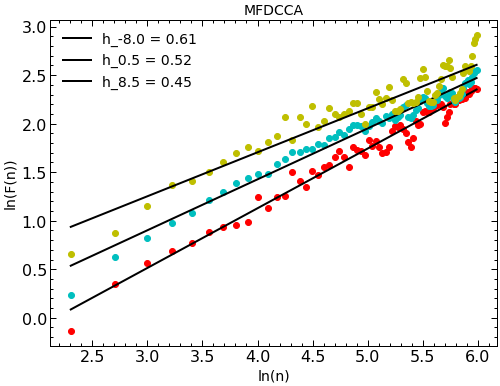

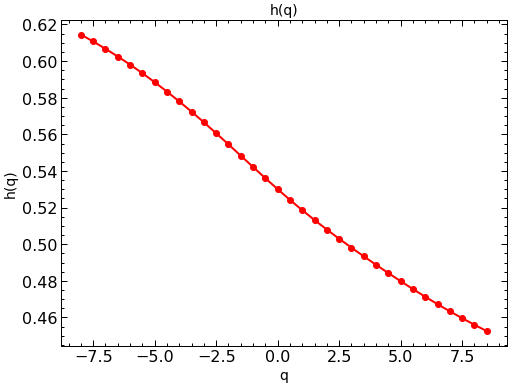

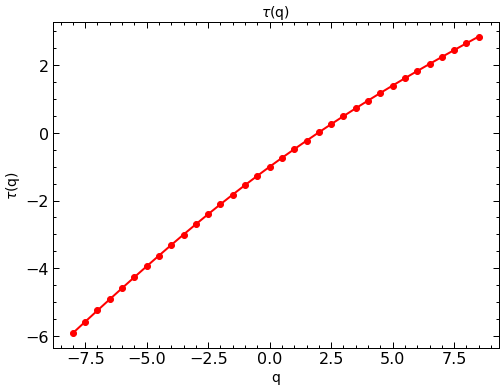

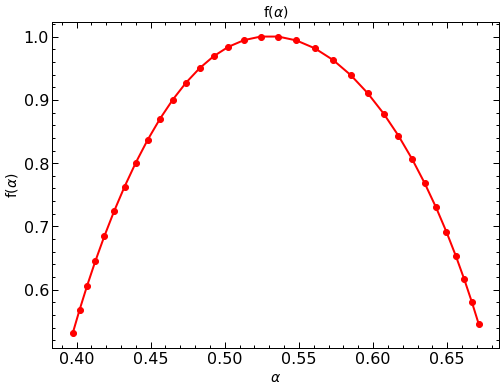

In [30]:
plt.plot(np.log(n), np.log(F[0, :]), 'ro')
plt.plot(np.log(n), list_H_intercept[0]+list_H[0]*np.log(n), 'k-', label='h_{:.1f} = {:.2f}'.format(qs[0], list_H[0]))
half_idx = int(len(qs)/2)
plt.plot(np.log(n), np.log(F[half_idx, :]), 'co')
plt.plot(np.log(n), list_H_intercept[half_idx]+list_H[half_idx]*np.log(n),
         'k-', label='h_{:.1f} = {:.2f}'.format(qs[half_idx], list_H[half_idx]))
plt.plot(np.log(n), np.log(F[-1, :]), 'yo')
plt.plot(np.log(n), list_H_intercept[-1]+list_H[-1]*np.log(n), 'k-',
         label='h_{:.1f} = {:.2f}'.format(qs[-1], list_H[-1]))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('MFDCCA', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.show()

plt.plot(qs, list_H, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('h(q)', fontsize=14)
plt.title('h(q)', fontsize=14)
plt.show()

tau = pymfdcca.computeMassExponents()

plt.plot(qs, tau, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('$\\tau$(q)', fontsize=14)
plt.title('$\\tau$(q)', fontsize=14)
plt.show()

alpha, mfSpect = pymfdcca.computeMultifractalSpectrum()

plt.plot(alpha, mfSpect, 'ro-')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('f($\\alpha$)', fontsize=14)
plt.title('f($\\alpha$)', fontsize=14)
plt.show()

### Tahity vs SOI

In [31]:
pymfdcca = fathon.MFDCCA(b, c)
start = 10
#stop = len(a)/4
stop = 400
sStep = 5
winSizes = fu.linRangeByStep(start, stop, step=sStep)
polOrd = 1
revSeg = False
qs = np.arange(-8, 9, 0.5)

n, F = pymfdcca.computeFlucVec(winSizes, qs, revSeg=revSeg, polOrd=polOrd)
list_H, list_H_intercept = pymfdcca.fitFlucVec()

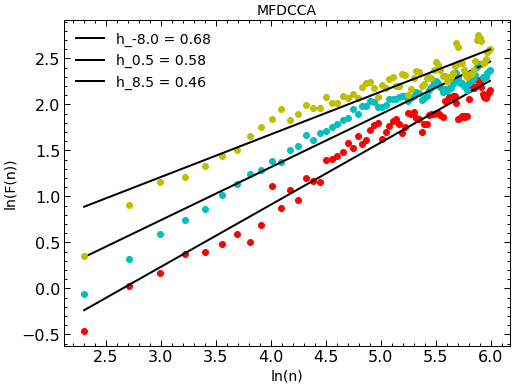

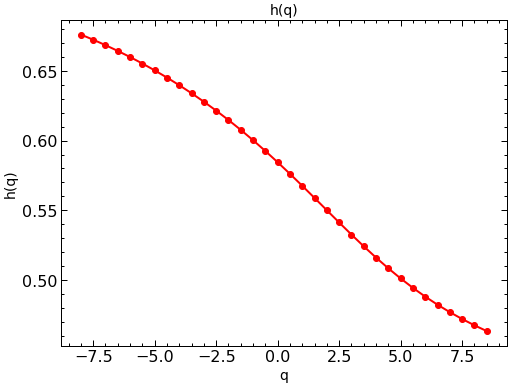

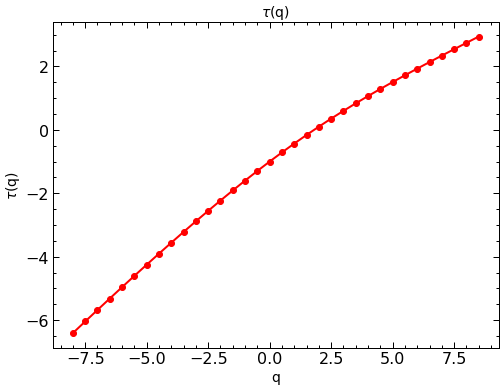

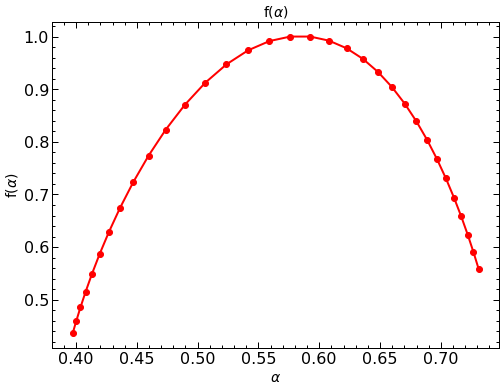

In [32]:
plt.plot(np.log(n), np.log(F[0, :]), 'ro')
plt.plot(np.log(n), list_H_intercept[0]+list_H[0]*np.log(n), 'k-', label='h_{:.1f} = {:.2f}'.format(qs[0], list_H[0]))
half_idx = int(len(qs)/2)
plt.plot(np.log(n), np.log(F[half_idx, :]), 'co')
plt.plot(np.log(n), list_H_intercept[half_idx]+list_H[half_idx]*np.log(n),
         'k-', label='h_{:.1f} = {:.2f}'.format(qs[half_idx], list_H[half_idx]))
plt.plot(np.log(n), np.log(F[-1, :]), 'yo')
plt.plot(np.log(n), list_H_intercept[-1]+list_H[-1]*np.log(n), 'k-',
         label='h_{:.1f} = {:.2f}'.format(qs[-1], list_H[-1]))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('MFDCCA', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.show()

plt.plot(qs, list_H, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('h(q)', fontsize=14)
plt.title('h(q)', fontsize=14)
plt.show()

tau = pymfdcca.computeMassExponents()

plt.plot(qs, tau, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('$\\tau$(q)', fontsize=14)
plt.title('$\\tau$(q)', fontsize=14)
plt.show()

alpha, mfSpect = pymfdcca.computeMultifractalSpectrum()

plt.plot(alpha, mfSpect, 'ro-')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('f($\\alpha$)', fontsize=14)
plt.title('f($\\alpha$)', fontsize=14)
plt.show()